In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats import shapiro
from scipy.stats.mstats import winsorize
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df = pd.read_csv('../dataset/윈저데이터셋.csv', encoding='CP949')

In [4]:
df_1 = df[[ '[제조]매출액증가율',
       '[제조]유형자산증가율', '[제조]비유동자산증가율', '[제조]총자본증가율', '[제조]자기자본증가율',
       '[제조]유동자산증가율', '[제조]순이익증가율', '[제조]재고자산증가율', '[제조]매출액총이익률',
       '[제조]매출액순이익률', '[제조]총자본사업이익률', '[제조]총자본순이익률', '[제조]자기자본순이익률',
       '[제조]1주당순이익', '[제조]1주당매출액', '[제조]총자본회전률', '[제조]자기자본회전률', '[제조]비유동자산회전률',
       '[제조]재고자산회전률', '[제조]매출채권회전률', '[제조]매입채무회전률', '[제조]매입채무회전기간',
       '[제조]재고자산회전기간', '[제조]매출채권회전기간', '[제조]1회전기간', '[제조]운전자본회전률',
       '[제조]순운전자본회전률', '[제조]유동자산회전률', '[제조]당좌자산회전률', '[제조]유동비율', '[제조]당좌비율',
       '[제조]현금비율', '[제조]부채비율', '[제조]순운전자본비율', '[제조]자기자본배율', '[제조]비유동비율',
       '[제조]유동자산구성비율', '[제조]자기자본구성비율', '[제조]부가가치', '[제조]총자본투자효율', '[제조]설비투자효율',
       '[제조]기계투자효율', '[제조]부가가치율', '[제조]노동소득분배율', '[제조]자본분배율', '[제조]이윤분배율',
       '[제조]유형자산회전율', '[제조]이자보상배율(이자비용)','label']]

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_1)

df_scaled = scaler.transform(df_1)

df_scaled_df = pd.DataFrame(df_scaled,columns = df_1.columns)

## 로지스틱을 활용해 피처선정

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
import numpy as np
lr_clf = LogisticRegression()

feature = df_scaled_df.drop(columns='label')
target = df_1['label']

logit = SelectFromModel(LogisticRegression())
logit.fit(feature, target)
logit_support = logit.get_support()
lr_feature = feature.loc[:,logit_support].columns.tolist()


In [7]:
lr_feature

['[제조]총자본증가율',
 '[제조]총자본사업이익률',
 '[제조]1주당매출액',
 '[제조]비유동자산회전률',
 '[제조]매출채권회전률',
 '[제조]매출채권회전기간',
 '[제조]순운전자본회전률',
 '[제조]당좌비율',
 '[제조]현금비율',
 '[제조]순운전자본비율',
 '[제조]자기자본배율',
 '[제조]노동소득분배율',
 '[제조]이윤분배율',
 '[제조]이자보상배율(이자비용)']

### 뽑힌 피처들의 VIF와 히트맵 확인 후 다중공선성 제거
- 피처들 중 높은 값이 나온 피처를 하나씩 제거하면서 확인

In [9]:
df_lr = df[['[제조]총자본증가율',
 '[제조]총자본사업이익률',
 '[제조]1주당매출액',
 '[제조]비유동자산회전률',
 '[제조]매출채권회전률',
 '[제조]매출채권회전기간',
 '[제조]순운전자본회전률',
 '[제조]당좌비율',
 '[제조]현금비율',
 '[제조]순운전자본비율',
 '[제조]자기자본배율',
 '[제조]노동소득분배율',
 '[제조]이윤분배율',
 '[제조]이자보상배율(이자비용)']]

In [10]:
def vif(data):
    import pandas as pd
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    # VIF 출력을 위한 데이터 프레임 형성
    vif = pd.DataFrame()

    # VIF 값과 각 Feature 이름에 대해 설정
    vif["VIF Factor"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    vif["features"] = data.columns 

    # VIF 값이 높은 순으로 정렬
    vif = vif.sort_values(by="VIF Factor", ascending=False)
    vif = vif.reset_index().drop(columns='index')
    
    return vif

vif(df_lr)

,VIF Factor,features
0,8.981055,[제조]당좌비율
1,8.531406,[제조]순운전자본회전률
2,7.273617,[제조]순운전자본비율
3,5.961152,[제조]비유동자산회전률
4,4.685052,[제조]노동소득분배율
5,4.677259,[제조]자기자본배율
6,4.643679,[제조]현금비율
7,4.421985,[제조]매출채권회전률
8,4.186190,[제조]1주당매출액
9,3.525085,[제조]매출채권회전기간


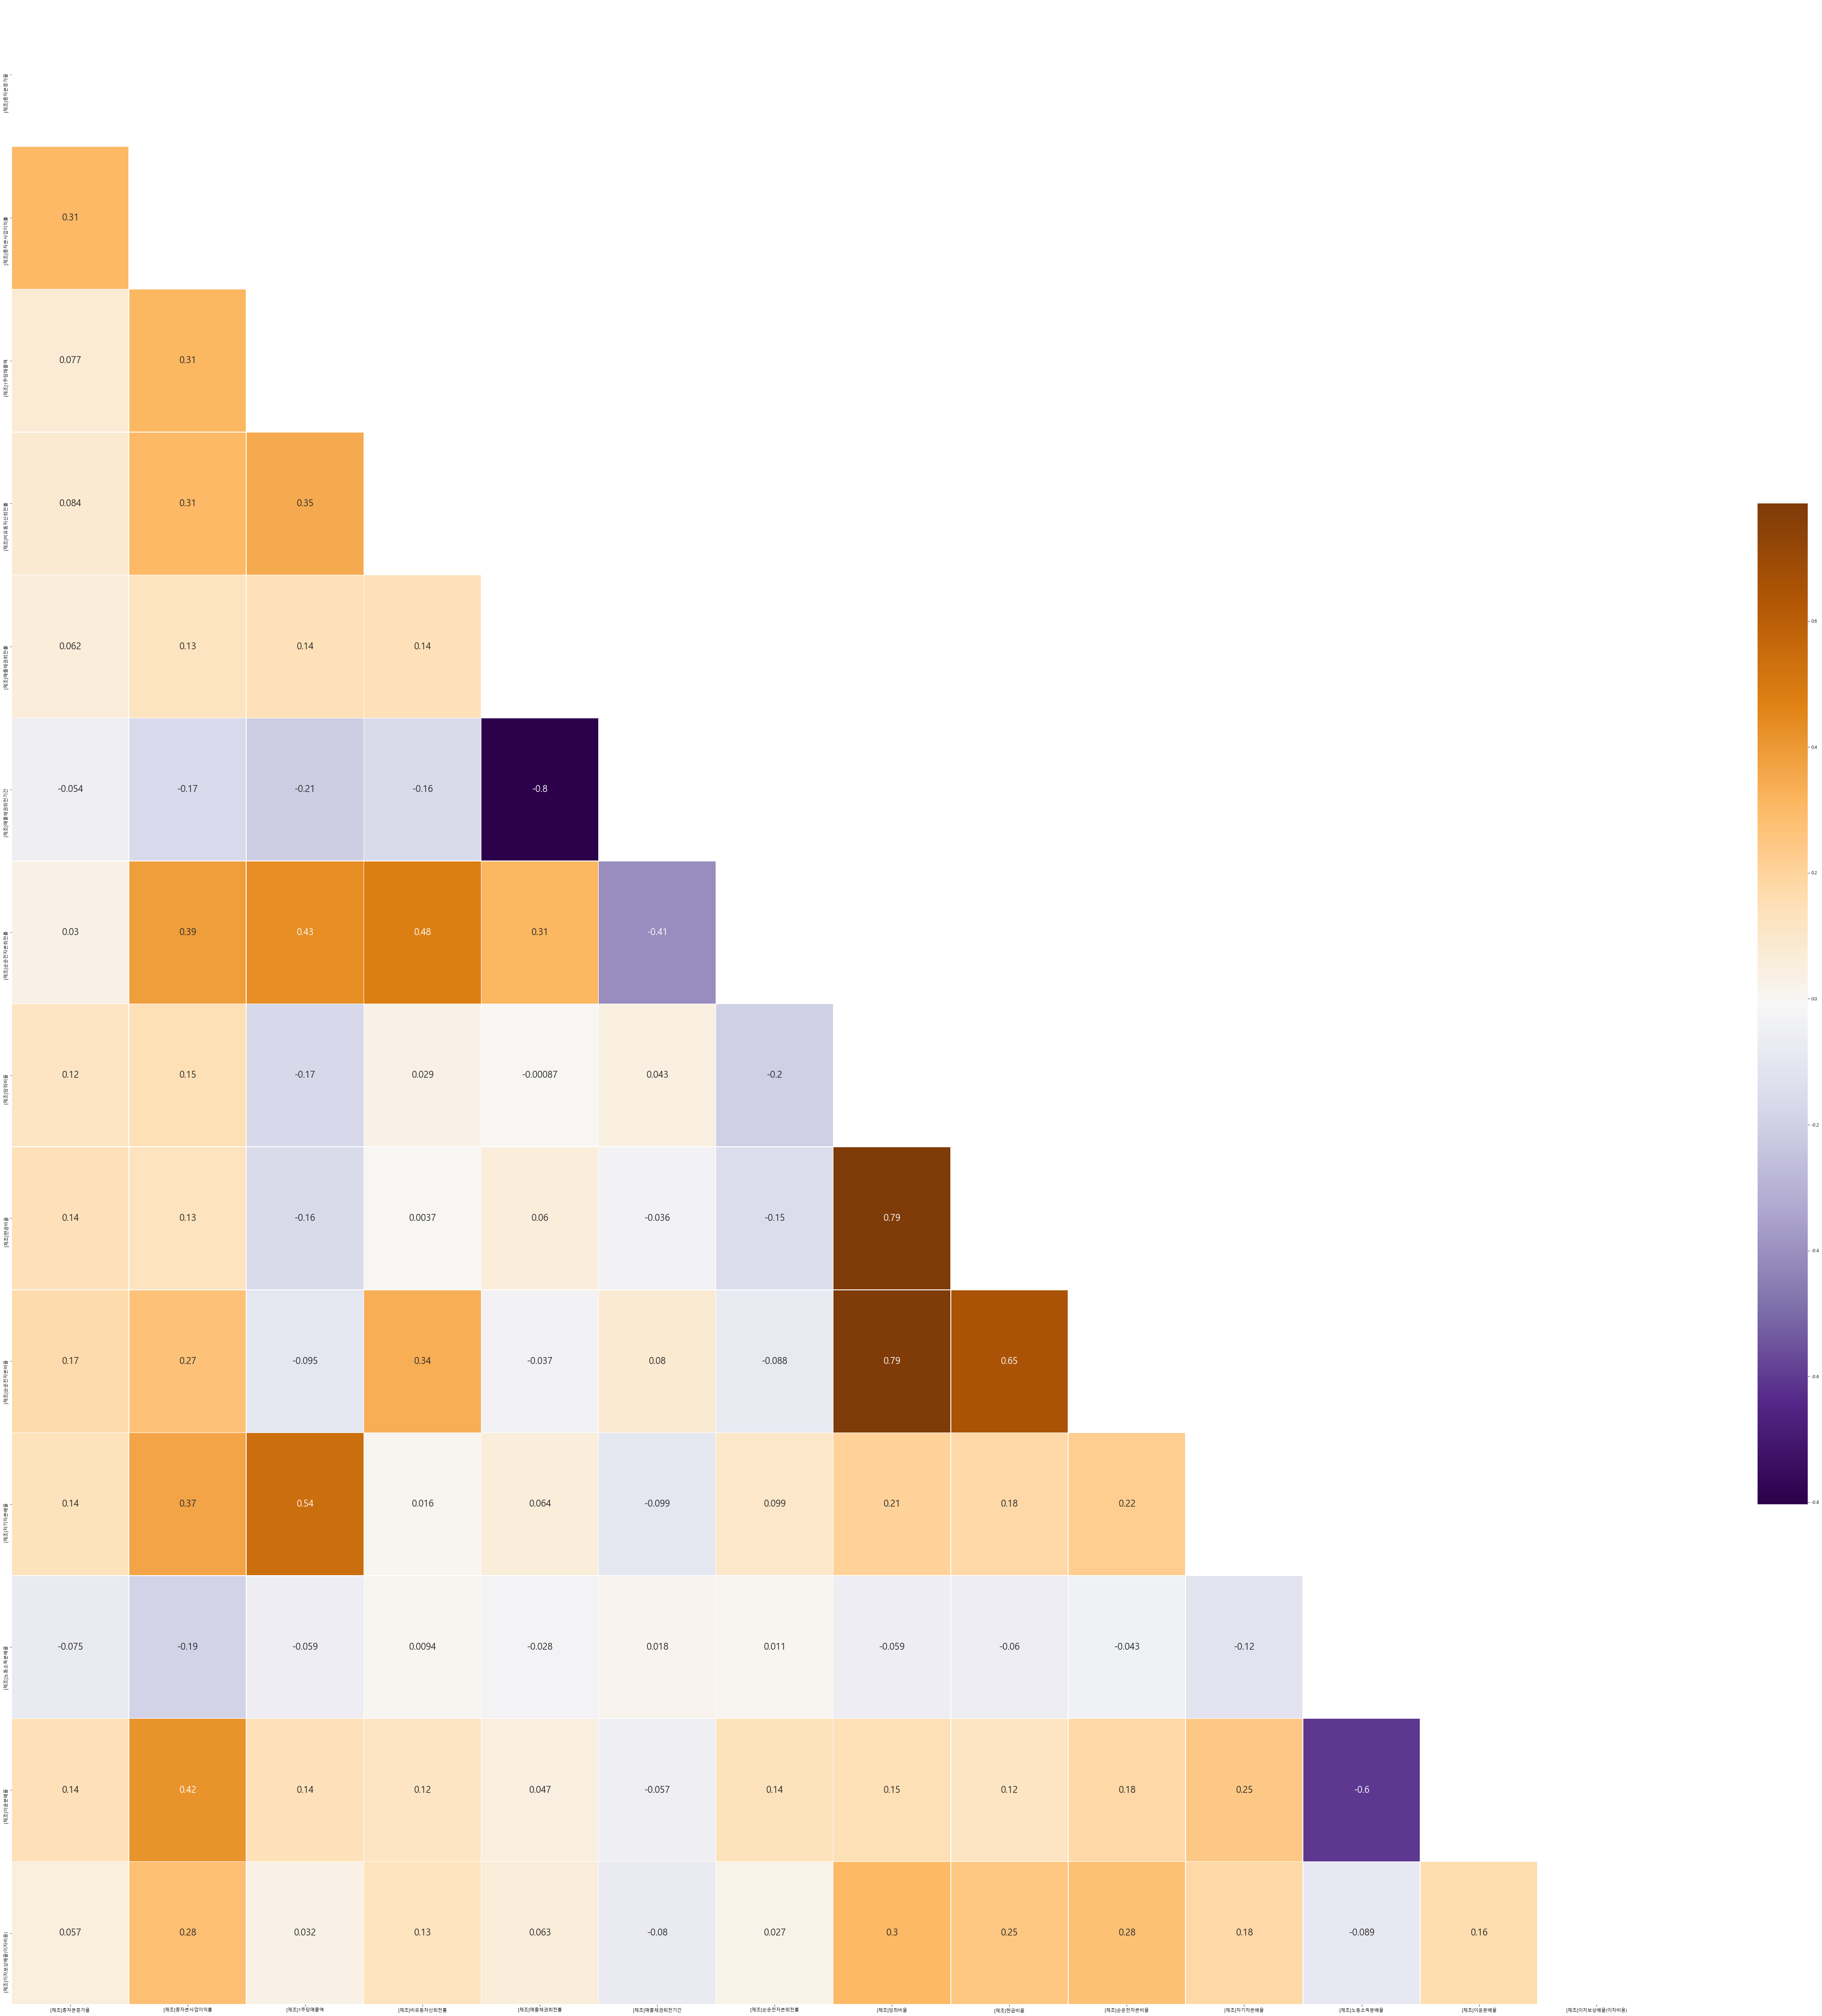

In [12]:
def corr_heatmap(dataset, method_option = 'pearson'):

    
    # heatmap 그리기
    mask_ut=np.triu(np.ones(dataset.corr().shape)).astype(bool) 
    plt.figure(figsize=(80,80))
    sns.heatmap(dataset.corr(method=method_option), annot = True, cmap = 'PuOr_r', cbar_kws={"shrink": .5}, 
                annot_kws={"size": 20}, linewidths=.5, mask=mask_ut)
    plt.show()

# 함수 사용
corr_heatmap(df_lr)